## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow_probability import edward2 as ed
%matplotlib inline

# Configuration

Now we define the learning method and the number of models of the ensemble. 



In [2]:
## Learning Method
# 0. MAP Learning 
# 2. PAC$^2$-Ensemble Learning
# 3. PAC$^2_T$-Ensemble Learning

LEARNING_METHOD = 3

## Control the presence of model miss-specficication as shown in Figures 2 and 3. 
MODEL_MISSSPECIFICATION = True

## Number of ensemble models.
K=3

# Data Set

In this first part, we present the data set used for this example. By setting the flag ``MODEL_MISSSPECIFICATION`` we can generate the figures under perfect model specification or under model miss-specification. 

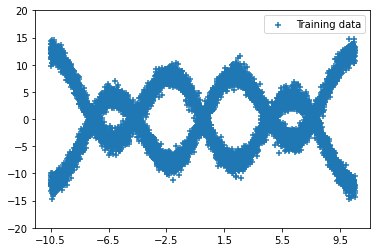

In [3]:
# Set seeds for reproducibility
np.random.seed(0)
tf.set_random_seed(1)
VAR=1.
NSAMPLE = 10000

x_train = np.linspace(-10.5, 10.5, np.int(NSAMPLE/2)).reshape(-1, 1)
r_train = np.float32(np.random.normal(size=(np.int(NSAMPLE/2),1),scale=VAR))
y_train = np.float32(np.sin(0.75*x_train)*7.0+x_train*0.5+r_train*1.0)
x_train2 = np.linspace(-10.5, 10.5, np.int(NSAMPLE/2)).reshape(-1, 1)
r_train2 = np.float32(np.random.normal(size=(np.int(NSAMPLE/2),1),scale=VAR))
y_train2 = -np.float32(np.sin(0.75*x_train2)*7.0+x_train2*0.5+r_train2*1.0)
x_train = np.concatenate((x_train,x_train2))
y_train = np.concatenate((y_train,y_train2))

plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.ylim(-20,20)
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend()
plt.show()

# Learning a Neural Network

We now employ Tensorflow Probability and Edward 2 to define and make varitional inference over a Bayesian neural network. 

In [4]:
NHIDDEN = 20

x = tf.placeholder("float", shape=[None, 1])
y = tf.placeholder("float", shape=[None, 1])

def model(NHIDDEN, x):
    W = tf.Variable(tf.random_normal([1, NHIDDEN], 0.0, 0.05, dtype=tf.float32))
    b = tf.Variable(tf.random_normal([1, NHIDDEN], 0.0, 0.05, dtype=tf.float32))

    W_out = tf.Variable(tf.random_normal([NHIDDEN, 1], 0.0, 0.05, dtype=tf.float32))
    b_out = tf.Variable(tf.random_normal([1, 1], 0.0, 0.05, dtype=tf.float32))

    hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
    out = tf.matmul(hidden_layer, W_out) + b_out
    y = ed.Normal(loc=out, scale=1.0, name="y")

    return x, y


t = []
tpy = []
for i in range(K):
    px,py = model(NHIDDEN,x)
    t.append(py.distribution.log_prob(y))
    tpy.append(py)

/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.8/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  from ipykernel import kernelapp as app


## Defining the variational functionals

And, now, we define the functionals $\bar{\cal L}_{PB^2}(\rho)$ and $\bar{\cal L}_{PB^2_h}(\rho)$ for computing the posterior $\rho(\theta|D)$ and $\rho_h(\theta|D)$, respectively.

In [5]:
probs = tf.math.softmax(tf.Variable(tf.ones([K], dtype=tf.float32), trainable=False, name='probs'))


ensemble = tf.concat(t,1)
logmax = tf.stop_gradient(tf.math.reduce_max(ensemble,axis=1))
logmean = tf.stop_gradient(tf.math.reduce_logsumexp(ensemble+tf.reshape(tf.tile(tf.log(probs),[NSAMPLE]),[NSAMPLE,K]), axis=1) - tf.log(K + 0.0))
varlist = []

#####
inc = logmean-logmax
if (LEARNING_METHOD==3):
    hmax = 2*tf.stop_gradient(inc/tf.math.pow(1-tf.math.exp(inc),2) + tf.math.pow(tf.math.exp(inc)*(1-tf.math.exp(inc)),-1))
else:
    hmax = 1.
#####


for i in range(K):
    vari = 0.5*(tf.reduce_sum(tf.exp(2*ensemble[:,i]-2*logmax)*hmax,axis=0))
    for j in range(K):
        vari = vari - 0.5*tf.reduce_sum(tf.reduce_sum(tf.exp(ensemble[:,i] + ensemble[:,j] - 2*logmax)*hmax,axis=0))*probs[j]
    varlist.append(vari)

var=tf.stack(varlist,0)
dataenergy = tf.reduce_sum(ensemble,axis=0)

if (LEARNING_METHOD==2 or LEARNING_METHOD==3):
    elboEnsemble = dataenergy + var
else:
    elboEnsemble = dataenergy
    
pacelbo = tf.reduce_sum(tf.math.multiply(elboEnsemble,probs))

pacelbo = pacelbo - tf.reduce_sum(tf.math.multiply(probs,tf.log(probs)))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Optimizing the variational functionals

We perform gradient-based optimization of the above objective. 

In [6]:
num_epochs=3000
verbose=True
sess = tf.Session()
t = []
train =  tf.train.AdamOptimizer(0.01).minimize(-pacelbo)
init = tf.global_variables_initializer()
sess.run(init)

for i in range(num_epochs+1):
    t.append(-sess.run(pacelbo,feed_dict={x: x_train,y: y_train}))
    sess.run(train,feed_dict={x: x_train,y: y_train})
    if verbose:
        if i % 100 == 0:
            str_elbo = str(-t[-1])
            print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)



0 epochs	-188727.44
100 epochs	-262797.4
200 epochs	-262935.47
300 epochs	-262486.78
400 epochs	-261362.55
500 epochs	-259250.12
600 epochs	-257632.78
700 epochs	-256204.95
800 epochs	-257655.94
900 epochs	-258513.31
1000 epochs	-258907.8
1100 epochs	-259040.03
1200 epochs	-259089.69
1300 epochs	-259179.19
1400 epochs	-259054.33
1500 epochs	-259167.3
1600 epochs	-259182.48
1700 epochs	-259177.0
1800 epochs	-259225.1
1900 epochs	-259161.78
2000 epochs	-259029.94
2100 epochs	-258999.03
2200 epochs	-258973.72
2300 epochs	-258953.12
2400 epochs	-258884.11
2500 epochs	-258914.22
2600 epochs	-258981.8
2700 epochs	-258932.78
2800 epochs	-258958.28
2900 epochs	-258971.42
3000 epochs	-258996.5

## Evaluating the learned model
Once the model is learned, we evaluate how it makes predictions by ploting its associated epistemic and aleatoric uncertainty

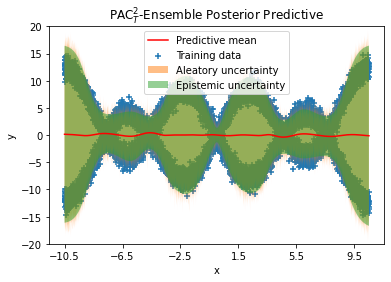

In [7]:
NSAMPLETEST = 10000
x_test = np.linspace(-10.5, 10.5, np.int(NSAMPLETEST/2)).reshape(-1, 1)
r_test = np.float32(np.random.normal(size=(np.int(NSAMPLETEST/2),1),scale=VAR))
y_test = np.float32(np.sin(0.75*x_test)*7.0+x_test*0.5+r_test*1.0)


x_test2 = np.linspace(-10.5, 10.5, np.int(NSAMPLETEST/2)).reshape(-1, 1)
r_test2 = np.float32(np.random.normal(size=(np.int(NSAMPLETEST/2),1),scale=VAR))
y_test2 = -np.float32(np.sin(0.75*x_test2)*7.0+x_test2*0.5+r_test2*1.0)

x_test2 = np.concatenate((x_test,x_test2))
y_test2 = np.concatenate((y_test,y_test2))

y_pred_list = []
y_pred_noise = []

for i in range(K):
    [mean, noise] = sess.run([tpy[i].distribution.mean(), tpy[i]], feed_dict={x: x_test})
    y_pred_list.append(mean)
    y_pred_noise.append(noise)

y_preds = np.concatenate(y_pred_list, axis=1)
y_preds_noise = np.concatenate(y_pred_noise, axis=1)

w = sess.run(probs)
y_mean = np.average(y_preds, weights = w, axis=1)
y_sigma = np.sqrt(np.average(np.power(y_preds,2), weights = w, axis=1) - y_mean**2)

y_mean_noise = np.average(y_preds_noise, weights = w, axis=1)
y_sigma_noise = np.sqrt(np.average(np.power(y_preds_noise,2), weights = w, axis=1) - y_mean_noise**2)

plt.plot(x_test, y_mean.reshape(-1, 1), 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma_noise,
                 y_mean - 2 * y_sigma_noise,
                 alpha=0.5, label='Aleatory uncertainty')

plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma,
                 alpha=0.5, label='Epistemic uncertainty')


plt.ylabel('y')
plt.xlabel('x')
plt.ylim(-20,20)
#plt.xticks(np.arange(-20., 20.5, 4))
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend();


dataname = 'Sindata'

if (LEARNING_METHOD==3):
    plt.title(r'PAC$^2_T$-Ensemble Posterior Predictive')
elif (LEARNING_METHOD==2):
    plt.title(r'PAC$^2$-Ensemble Posterior Predictive')
else:
    plt.title(r'(MAP)-Ensemble Posterior Predictive')

plt.show()


Let's have a look at the indivual models of the ensemble.

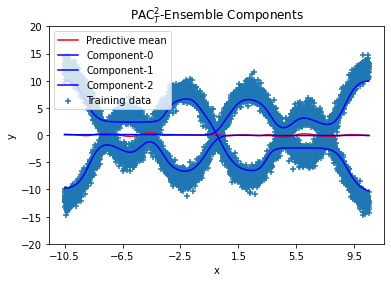

In [8]:

#plt.figure(figsize=(8, 8))
plt.plot(x_test, y_mean.reshape(-1, 1), 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')

for i in range(K):
    plt.plot(x_test, y_preds[:,i], 'b-',label='Component-'+str(i));

plt.ylabel('y')
plt.xlabel('x')
plt.ylim(-20,20)
#plt.xticks(np.arange(-20., 20.5, 4))
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend();

if (LEARNING_METHOD==3):
    plt.title(r'PAC$^2_T$-Ensemble Components')
elif (LEARNING_METHOD==2):
    plt.title(r'PAC$^2$-Ensemble Components')
else:
    plt.title(r'(MAP)-Ensemble Components')

plt.show()


We also compute the *log-likelihood of the predicitive posterior* over the independent test data set.

In [9]:
y_pred_list = []
for i in range(K):
    y_pred_list.append(tpy[i].distribution.log_prob(y_test2)+tf.log(probs[i]))

y_preds = tf.concat(y_pred_list, axis=1)

score = tf.reduce_sum(tf.math.reduce_logsumexp(y_preds,axis=1)-tf.log(K+0.0))

score = sess.run(score,feed_dict={x: x_test2})

print("\n Negative Log-likelihood of the posterior predictive : "+str(score))


 Negative Log-likelihood of the posterior predictive : -39964.438
